### CTCF Perturbation using SimpleNet

In this tutorial, we will learn how to use Ledidi to design genomic edits that affect CTCF binding in K562. For computational efficiency, we will use a very small neural network, named SimpleNet, in as the pre-trained oracle model that Ledidi relies on. SimpleNet can be run on a CPU in a reasonable amount of time, making it ideal for training purposes. However, this same simplicity means that SimpleNet does not exhibit state-of-the-art performance, and so the edits designed by Ledidi may not be as compact or targetted as more complex models.

In [1]:
%pylab inline

import pyBigWig
import seaborn; seaborn.set_style('whitegrid')

Populating the interactive namespace from numpy and matplotlib


### Visually validating SimpleNet-CTCF

Before we get to engineering sequences using Ledidi, lets get familiar with SimpleNet and make sure that the predictions that it is making are reasonable. We can start by loading the model up using the keras module in TensorFlow.

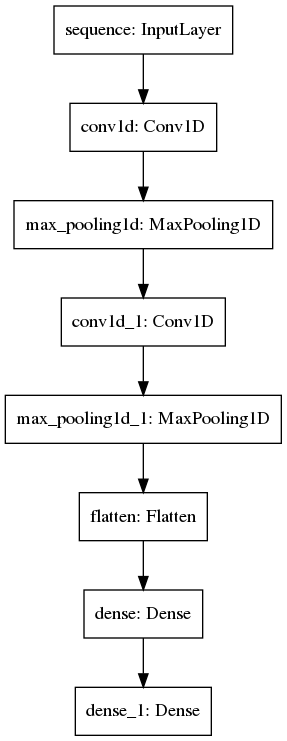

In [2]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model

model = load_model("SimpleNet-CTCF")
plot_model(model)

To validate the predictions of SimpleNet, we need to load up some nucleotide sequence to use as input to the model, as well as the experimental signal to compare the predictions against. The nucleotide sequence comes as a one-hot encoding, where each row is a position in the sequence, each column is a nucleotide, and a value of 1 means that position contains that nucleotide. The experimental signal is the fold-change, which is the observed read counts divided by the read counts from a control experiment. As a technical note, pyBigWig will return a signal array that has NaNs where no reads map to a position. We replace these NaNs with 0s.

Note: you will need to download the ENCFF050CCI.bigwig file from the ENCODE portal if you do not already have it.

In [3]:
ohe_chrom = numpy.load("chr1.npy", mmap_mode='r')
signal = pyBigWig.open("ENCFF050CCI.bigWig").values("chr1", 0, -1, numpy=True)
signal = numpy.nan_to_num(signal)

Now, let's visualize some of the predictions of SimpleNet against the actual experimental signal at regions with high experimental signal.

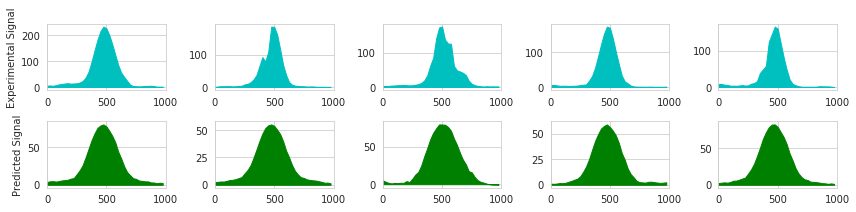

In [4]:
mids = signal.argsort()
x = numpy.arange(0, 1000, 25)

plt.figure(figsize=(12, 3))

for i, mid in enumerate(mids[::-100][:5]):
    start, end = mid - 500, mid + 500
    plt.subplot(2, 5, i+1)
    plt.fill_between(x, 0, signal[start:end].reshape(40, 25).mean(axis=1), color='c')
    plt.xlim(0, 1000)
    plt.ylabel("Experimental Signal" if i == 0 else None, fontsize=10)

    y_pred = model.predict(numpy.array(ohe_chrom[start:end, :4], ndmin=3))[0, :]

    plt.subplot(2, 5, 5+i+1)
    plt.fill_between(x, 0, y_pred, color='g')
    plt.xlim(0, 1000)
    plt.ylabel("Predicted Signal" if i == 0 else None, fontsize=10)

plt.tight_layout()
plt.show()

It looks like SimpleNet is able to predict peaks at each of these locations. A weakness seems to be that the predicted signal is significantly lower than the experimental signal (fold change).

Now let's look at some randomly selected positions that do not exhibit high experimental signal, to ensure that our model isn't simply making predictions of peaks everywhere.

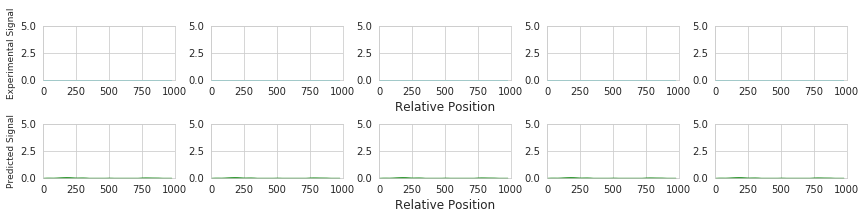

In [5]:
plt.figure(figsize=(12, 3))

for i, mid in enumerate(mids[10000::100][:5]):
    start, end = mid - 500, mid + 500
    plt.subplot(2, 5, i+1)
    plt.fill_between(x, 0, signal[start:end].reshape(40, 25).mean(axis=1), color='c')
    plt.xlim(0, 1000)
    plt.ylabel("Experimental Signal" if i == 0 else None, fontsize=9)
    plt.xlabel("Relative Position" if i == 2 else None, fontsize=12)
    plt.ylim(0, 5)

    y_pred = model.predict(numpy.array(ohe_chrom[start:end, :4], ndmin=3))[0, :]

    plt.subplot(2, 5, 5+i+1)
    plt.fill_between(x, 0, y_pred, color='g')
    plt.xlim(0, 1000)
    plt.ylabel("Predicted Signal" if i == 0 else None, fontsize=9)
    plt.xlabel("Relative Position" if i == 2 else None, fontsize=12)
    plt.ylim(0, 5)
    
plt.tight_layout()
plt.show()

Looks good!

### Using Ledidi

Using Ledidi in Python is fairly straightforward. The steps are as follows:

1. Pass your TensorFlow model into the built-in wrapper
2. Pass this wrapper object into the Ledidi object
3. Call the `fit_transform` method on the Ledidi object using the original sequence and desired output

Let's take these steps in order and pretend that we're starting from scratch, even though we've already loaded the SimpleNet model.

Step 1. Load the model and wrap it.

In [6]:
from tensorflow.keras.models import load_model
from ledidi import TensorFlowRegressor

model = load_model("SimpleNet-CTCF")
regressor = TensorFlowRegressor(model=model)

Step 2. Now, we need to pass the wrapped model into Ledidi, along with the parameters we want to use for our optimization.

In [7]:
from ledidi import Ledidi

mutator = Ledidi(regressor, l=1, max_iter=250, random_state=111)

This object is the one that will edit sequences given the hyperparameters of the optimization, e.g. lambda and the maximum number of iterations, and the pre-trained model.

Step 3. Now, we need to get our sequence (in one-hot encoded format) and our desired output. Both need to be 3 dimensional to fit in with the style of neural network prediction. This means that the first dimension should always have a size of 1 (because you are only editing one sequence at a time).

Let's say that our desired sequence is from a FIMO-identified motif hit and our goal is to knock out binding, i.e., exhibit no signal.

In [8]:
mid = signal.argmax()
start, end = mid - 500, mid + 500

ohe_sequence = numpy.load("CTCF-seqs.npz")['arr_0'][0][65036:66036]
desired_epi = numpy.zeros((1, 40))

Finally, we can run the optimization process using the `fit_transform` method. If you find the output annoying, you can set `verbose=False` when you create the Ledidi object.

In [9]:
edited_sequence = mutator.fit_transform(ohe_sequence, desired_epi)

batch_missing_loc_indices=0
iter=0	seq_loss= 0.0	seq_loss_discrete= 5.0	epi_loss=0.02418	epi_loss_discrete=2.336e+03	total_loss=0.02418	total_loss_discrete:2.341e+03
iter=1	seq_loss=268.3	seq_loss_discrete=12.0	epi_loss=0.05441	epi_loss_discrete=2.465e+03	total_loss=268.4	total_loss_discrete:2.477e+03
iter=2	seq_loss=277.9	seq_loss_discrete=14.0	epi_loss=0.1087	epi_loss_discrete=2.347e+03	total_loss=278.0	total_loss_discrete:2.361e+03
iter=3	seq_loss=264.4	seq_loss_discrete= 9.0	epi_loss=0.1016	epi_loss_discrete=2.398e+03	total_loss=264.5	total_loss_discrete:2.407e+03
iter=4	seq_loss=277.3	seq_loss_discrete=13.0	epi_loss=0.06721	epi_loss_discrete=533.5	total_loss=277.3	total_loss_discrete:546.5
iter=5	seq_loss=275.4	seq_loss_discrete=14.0	epi_loss=0.02912	epi_loss_discrete=2.232e+03	total_loss=275.4	total_loss_discrete:2.246e+03
iter=6	seq_loss=272.7	seq_loss_discrete=13.0	epi_loss=0.1082	epi_loss_discrete=2.569e+03	total_loss=272.8	total_loss_discrete:2.582e+03
iter=7	seq_loss=269.7	s

iter=62	seq_loss=227.8	seq_loss_discrete=10.0	epi_loss=0.01223	epi_loss_discrete=880.1	total_loss=227.9	total_loss_discrete:890.1
iter=63	seq_loss=234.4	seq_loss_discrete=15.0	epi_loss=0.01624	epi_loss_discrete=2.421e+03	total_loss=234.4	total_loss_discrete:2.436e+03
iter=64	seq_loss=236.3	seq_loss_discrete=12.0	epi_loss=0.004286	epi_loss_discrete=105.5	total_loss=236.3	total_loss_discrete:117.5
iter=65	seq_loss=227.8	seq_loss_discrete= 7.0	epi_loss=0.01878	epi_loss_discrete=2.238e+03	total_loss=227.8	total_loss_discrete:2.245e+03
iter=66	seq_loss=229.9	seq_loss_discrete=16.0	epi_loss=0.004733	epi_loss_discrete=1.244e+03	total_loss=229.9	total_loss_discrete:1.26e+03
iter=67	seq_loss=230.1	seq_loss_discrete=11.0	epi_loss=0.02622	epi_loss_discrete=2.345e+03	total_loss=230.1	total_loss_discrete:2.356e+03
iter=68	seq_loss=238.2	seq_loss_discrete=16.0	epi_loss=0.01333	epi_loss_discrete=2.624e+03	total_loss=238.2	total_loss_discrete:2.64e+03
iter=69	seq_loss=234.5	seq_loss_discrete=19.0	epi_

iter=122	seq_loss=215.4	seq_loss_discrete=19.0	epi_loss=0.0108	epi_loss_discrete=2.646e+03	total_loss=215.4	total_loss_discrete:2.665e+03
iter=123	seq_loss=217.6	seq_loss_discrete=22.0	epi_loss=0.02156	epi_loss_discrete=1.328e+03	total_loss=217.6	total_loss_discrete:1.35e+03
iter=124	seq_loss=213.7	seq_loss_discrete=14.0	epi_loss=0.01733	epi_loss_discrete=2.399e+03	total_loss=213.7	total_loss_discrete:2.413e+03
iter=125	seq_loss=223.6	seq_loss_discrete=22.0	epi_loss=0.009972	epi_loss_discrete=682.6	total_loss=223.7	total_loss_discrete:704.6
iter=126	seq_loss=217.2	seq_loss_discrete=11.0	epi_loss=0.007713	epi_loss_discrete=2.305e+03	total_loss=217.2	total_loss_discrete:2.316e+03
iter=127	seq_loss=220.8	seq_loss_discrete=22.0	epi_loss=0.008282	epi_loss_discrete=1.123e+03	total_loss=220.8	total_loss_discrete:1.145e+03
iter=128	seq_loss=215.6	seq_loss_discrete=12.0	epi_loss=0.01327	epi_loss_discrete=1.027e+03	total_loss=215.6	total_loss_discrete:1.039e+03
iter=129	seq_loss=216.8	seq_loss_d

iter=184	seq_loss=210.9	seq_loss_discrete=19.0	epi_loss=0.004595	epi_loss_discrete=2.658e+03	total_loss=210.9	total_loss_discrete:2.677e+03
iter=185	seq_loss=216.4	seq_loss_discrete=17.0	epi_loss=0.02312	epi_loss_discrete=2.132e+03	total_loss=216.4	total_loss_discrete:2.149e+03
iter=186	seq_loss=207.8	seq_loss_discrete=22.0	epi_loss=0.03796	epi_loss_discrete=2.374e+03	total_loss=207.9	total_loss_discrete:2.396e+03
iter=187	seq_loss=209.5	seq_loss_discrete=16.0	epi_loss=0.01231	epi_loss_discrete=2.557e+03	total_loss=209.5	total_loss_discrete:2.573e+03
iter=188	seq_loss=205.3	seq_loss_discrete=19.0	epi_loss=0.03198	epi_loss_discrete=1.019e+03	total_loss=205.3	total_loss_discrete:1.038e+03
iter=189	seq_loss=213.7	seq_loss_discrete=24.0	epi_loss=0.005462	epi_loss_discrete=2.165e+03	total_loss=213.7	total_loss_discrete:2.189e+03
iter=190	seq_loss=213.6	seq_loss_discrete=14.0	epi_loss=0.01583	epi_loss_discrete=2.291e+03	total_loss=213.7	total_loss_discrete:2.305e+03
iter=191	seq_loss=214.1	s

iter=246	seq_loss=209.2	seq_loss_discrete=22.0	epi_loss=0.06886	epi_loss_discrete=2.283e+03	total_loss=209.2	total_loss_discrete:2.305e+03
iter=247	seq_loss=198.1	seq_loss_discrete=13.0	epi_loss=0.009174	epi_loss_discrete=2.28e+03	total_loss=198.1	total_loss_discrete:2.293e+03
iter=248	seq_loss=203.2	seq_loss_discrete=15.0	epi_loss=0.05043	epi_loss_discrete=2.298e+03	total_loss=203.2	total_loss_discrete:2.313e+03
iter=249	seq_loss=200.6	seq_loss_discrete=27.0	epi_loss=0.05383	epi_loss_discrete=2.527e+03	total_loss=200.7	total_loss_discrete:2.554e+03


Great. The return from the `fit_transform` is the edited sequence in one-hot encoded format. If you want to take a look at the sequence in canonical form, you can do the following:

In [10]:
''.join(numpy.array(['A', 'C', 'G', 'T'])[edited_sequence.argmax(axis=1)])

'CAAAACGCAGAGAGAGGGGGGGGAAGGGACTTGACGTTTCCTGAGTGCATCTTTGGTGCCAGGCTCTGTTCTGGTCTTCTCAGACTTGATGTAATTGTCTTCACAATTCTGTGAAGATGGAGTTGGTGTCTCTGCTTCACATGAAGGGACCTGAGGTTCAGAGAGGCTAAGTAACTTTCCTAGGTCACAGAGCTGGTAAGTAGAGACTTTAGTGTTCAAAACCAGAGCAGTCCGACCCCAGAGCCTGGGACCGCAGAGGTAGACAGTGATACTCAGTGAGTGCTTGGAGCCCACAGAGGGTGGAGGGAGTGATTCCTGGATGAGGTAGATCTGAAGGGTGGGTGAGGTTCATTTGAAAGGCGAGAATTGGAGGCATGTCTGGAAGTTGGTGCTGGTGGTGCCCAGGGAGACTTGCAGGTTGATCAGGTGGCCGGCTTGCATGGATCGTGGGGAGCAGGGGACAGGTTCAAAGAAACACATCTTTAAACATTGGACACCAGGTGCCGCCGCGGGCCAATTCCTAGAAGCGGCTCCAGCCTCAGCGCCCTCACTAAGGCCCAGGTATGACTTCGCTGCTCAGCCAGGGCTCCATGCTCGGCTTGCTTCCTCAGGTGTCATCTCCAGCTTCCGCTTGCCCCTGGCTTCTGGCATCCAACACACGGGGGATAATGATGCTACCAGTCGTTTCCTGACTCGGGACGAACACCCAGGTAGCTGAGACCTTGGAATCCCCGTGGGTCTGAGCAGCTCCCCCGGTCACCCGGAGACCCCTACAGTCGCCTAAACCTGGCTTCATGTCCAGCGCCCTTCTGAGTTTCTGGGAGACACTGTTCAGAGGACAGGCTGAGGAAACAGGCTTTTGAGTCCAACTGACCTGGGTCTGAAGGGAAATAATAATATCTACCTTGTAAGGATTTAAAACATTTCATATATGGCCAGGTGCGGCGGCCCACCCCTGTAATCCCAGCACTTTGGGAGGCCGAGGCGGGCAGATCACCT

Perhaps more informatively we can look at the difference in predicted signal when using the original sequence and when using the edited sequence.

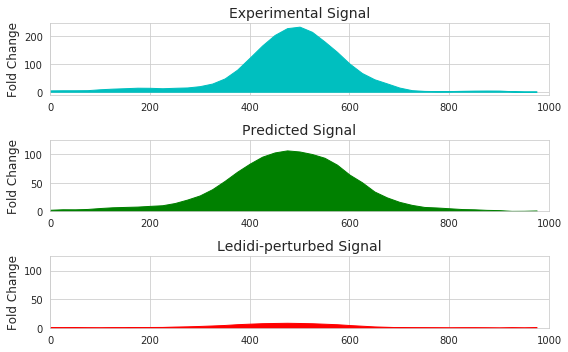

In [11]:
mid = signal.argmax()
start, end = mid - 500, mid + 500
x = range(0, 1000, 25)

y_pred = model.predict(ohe_sequence.reshape(1, 1000, 4))[0, :]
y_new_pred = model.predict(edited_sequence.reshape(1, 1000, 4))[0, :]

plt.figure(figsize=(8, 5))
plt.subplot(311)
plt.title("Experimental Signal", fontsize=14)
plt.fill_between(x, 0, signal[start:end].reshape(40, 25).mean(axis=1), color='c')
plt.ylabel("Fold Change", fontsize=12)
plt.xlim(0, 1000)

plt.subplot(312)
plt.title("Predicted Signal", fontsize=14)
plt.fill_between(x, 0, y_pred, color='g')
plt.ylabel("Fold Change", fontsize=12)
plt.ylim(0, 125)
plt.xlim(0, 1000)

plt.subplot(313)
plt.title("Ledidi-perturbed Signal", fontsize=14)
plt.fill_between(x, 0, y_new_pred, color='r')
plt.ylabel("Fold Change", fontsize=12)
plt.ylim(0, 125)
plt.xlim(0, 1000)

plt.tight_layout()
plt.show()

Looks like we are significantly reducing the predicted CTCF binding signal.

### Evaluating Ledidi

Now that we have the edited sequence, how can we evaluate it? Well, there are several performance measures that we can use to evaluate the edited sequence. The most intuitive initial question is: does this sequence achieve the desired result? The simplest performance measure for this question is the mean-squared-error between the desired output and the predicted signal from the edited sequence, perhaps compared to the mean-squared-error when using the original sequence.

In [12]:
y_pred = model.predict(ohe_sequence.reshape(1, 1000, 4))[0, :]
y_new_pred = model.predict(edited_sequence.reshape(1, 1000, 4))[0, :]

print(((y_new_pred - desired_epi) ** 2).mean())
print(((y_pred - desired_epi) ** 2).mean())

16.379480067507963
2363.7000761723416


An equally valid question is: how different is the edited sequence from my original sequence?

In [13]:
edits = ohe_sequence.argmax(axis=1) != edited_sequence.argmax(axis=1)

numpy.sum(edits)

24

That seems high for the CTCF motif, which is only length 19. This is due, in large part, to the SimpleNet-CTCF model being a very simple model. When using a more complicated model, Ledidi has been able to knock out CTCF activity using only a single nucleotide, and a median of ~3 nucleotides.

However, let's look more specifically at the edits being proposed.

In [14]:
for i in range(490, 510):
    print(i, 'ACGT'[ohe_sequence[i].argmax()], 'ACGT'[edited_sequence[i].argmax()])

490 T T
491 G G
492 G G
493 C A
494 C C
495 A A
496 C C
497 C C
498 A A
499 G G
500 G G
501 T T
502 G G
503 G C
504 C C
505 G G
506 C C
507 C C
508 G G
509 C C
